In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn.functional as F

In [3]:
words = open('names.txt').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [4]:
# let's only have one special token, and let's have it at index 0, offset others by 1
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
num_classes = len(stoi)
vocab_size = len(itos)
print(vocab_size, itos)

27 {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
def build_dataset(words, block_size):
    X, Y, = [], [] # X, input | Y, labels

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append moving window

    X = torch.tensor(X)
    Y = torch.tensor(Y)    
    return X, Y

In [6]:
# Splits
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

block_size = 3 # context length : How many characters do we take to predict the next one : 3 chars to predict the 4th

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xva, Yva = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

Xtr.shape, Ytr.shape, Xva.shape, Yva.shape, Xte.shape, Yte.shape

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

In [7]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 200 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g)
b2 = torch.randn(vocab_size,                       generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # total number of parameters

11897

In [8]:
max_steps = 200000
batch_size = 32

In [9]:
lossi = []
losslog10i = []
stepsi = []

In [10]:
tot_steps = len(stepsi)

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]                         # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1          # hidden layer pre-activation
    h = torch.tanh(hpreact)             # hidden layer
    logits = h @ W2 + b2                # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01    # switch learning rate
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    losslog10i.append(loss.log10().item())
    
    # Print loss 
    if (i)%(max_steps/10) == 0:
        print(f"Loss {i}/{max_steps}: {loss.item()}")
    
    break

Loss 0/200000: 27.881732940673828


In [11]:
# We have broken right at the first iteration
# Let's investigate a bit more

In [12]:
# We can see above in the loss for 0th iteration that the loss is very high (27.)
# When training neural nets it's always the case that you have an idea of what loss to expect at initilisation
# Depends on the loss function and problem setup
# In this case we expect a much lower number

In [13]:
# 27 possible characters that can be output
# At init, no reason to believe that any character is much more likely to be than others
# we'd expect the prob distribution that comes out initially to be a uniform distribution
# assigning about equal probability to all the 27 characters
# prob for any character to be 1/27
# loss is negative log prob

In [14]:
-torch.tensor(1.0/27.0).log()

tensor(3.2958)

In [15]:
# so we can see that the expected loss for uniform distribution should have been around 3.29, much much lower than 27
# what's happening at init is that the prob. distributions are all messed up
# some characters very confident and some characters not at all
# the network is very confidently wrong, so we get a high loss

In [16]:
# look at some examples, say we want the probability on the index i = 2

In [17]:
# first a uniform distribution
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, probs[2], loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(0.2500),
 tensor(1.3863))

In [18]:
# next if it's correct
logits = torch.tensor([0.0, 0.0, 9.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, probs[2], loss

(tensor([0., 0., 9., 0.]),
 tensor([1.2336e-04, 1.2336e-04, 9.9963e-01, 1.2336e-04]),
 tensor(0.9996),
 tensor(0.0004))

In [19]:
# next if it's wrong, if some other indexes are correct
logits = torch.tensor([10.0, 10.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, probs[2], loss

(tensor([10., 10.,  0.,  0.]),
 tensor([4.9998e-01, 4.9998e-01, 2.2699e-05, 2.2699e-05]),
 tensor(2.2699e-05),
 tensor(10.6932))

In [20]:
# So basically when the logits take on extreme values we record really high loss

In [21]:
# now lets take some uniformly distributed random numbers
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, probs[2], loss

(tensor([ 1.5616, -0.1178,  0.7796, -0.0252]),
 tensor([0.5410, 0.1009, 0.2475, 0.1107]),
 tensor(0.2475),
 tensor(1.3964))

In [22]:
# but what if those numbers are not near zero
logits = torch.randn(4) * 30
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, probs[2], loss

(tensor([  0.8477, -17.5825,  29.2880,  20.6880]),
 tensor([4.4508e-13, 4.4088e-21, 9.9982e-01, 1.8406e-04]),
 tensor(0.9998),
 tensor(0.0002))

In [23]:
# confidently wrong and therefore recording high loss

In [24]:
# WE want the logits to be roughly around zero when the network is first initialised
# what we did in the first example
# In fact they don't have to be all zero, they just have to be all equal
# everything is equally likely

In [25]:
logits[0]

tensor(0.8477)

In [26]:
# the logits take on quite extreme values, that's what's creating the fake confidence and making loss high
# how can we make these logits coming out of the NN more close to zero

# Notice logits = h @ W2 + b2
# we init b2 as random values, but since we want logits to come out close to zero, lets just zero the biases out to start with
# b2 = torch.randn(vocab_size,                       generator=g) * 0.0
# the other component is h @ W2, if we want logits to be small, we can scale down those values
# W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
# the loss that we want to start with for this network is
# -torch.tensor(1.0/27.0).log() = tensor(3.2958)

# But why not just set W2 to 0, that way we get exactly 3.2958
# you want it to be small numbers instead of exactly zero, you want some entropy
# the entropy is used for symmetry breaking (explained further)

# so let's try to reinit and run the training again

In [27]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 200 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0.0
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # total number of parameters

11897

In [28]:
max_steps = 200000
batch_size = 32

In [29]:
lossi = []
losslog10i = []
stepsi = []

In [30]:
tot_steps = len(stepsi)

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]                         # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1          # hidden layer pre-activation
    h = torch.tanh(hpreact)             # hidden layer
    logits = h @ W2 + b2                # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01    # switch learning rate
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    losslog10i.append(loss.log10().item())
    
    # Print loss 
    if (i)%(max_steps/10) == 0:
        print(f"Loss {i}/{max_steps}: {loss.item()}")

Loss 0/200000: 3.32205867767334
Loss 20000/200000: 2.4195706844329834
Loss 40000/200000: 2.0601015090942383
Loss 60000/200000: 2.3902440071105957
Loss 80000/200000: 2.336879253387451
Loss 100000/200000: 1.8328931331634521
Loss 120000/200000: 1.8539730310440063
Loss 140000/200000: 2.1878631114959717
Loss 160000/200000: 1.8955609798431396
Loss 180000/200000: 2.0325779914855957


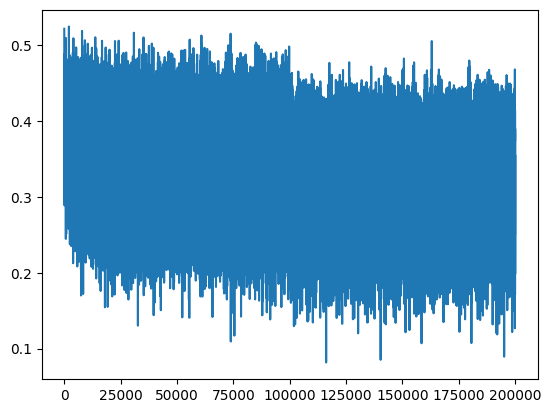

In [31]:
plt.plot(stepsi, losslog10i)

In [32]:
# you can see that the training started at a much stable/expected loss
# LOSS Curve DOES NOT look like hockey stick either
# right in the beginning, the logits are being squashed immediately, and then being rearranged
# we don't get easy gains in the beginning, instead we can use the compute to focus on the hard gain
# think of it as letting the NN start from a better place

In [33]:
@torch.no_grad() # this decorator disables gradient tracking, can also the context manager instead
def split_loss(split):
    ds = {
        'train': (Xtr, Ytr),
        'val':   (Xva, Yva),
        'test':  (Xte, Yte),
    }
    x,y = ds[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss : {loss.item()}')

split_loss('train')
split_loss('val')

train loss : 2.069589138031006
val loss : 2.1310744285583496


In [34]:
# And the losses have improved quite a bit
# already much better than previous nb if you go back and compare

# We are spending more cycles optimizing the NN actually
# instead of spending lots of iterations just squashing the randomness in logits(via weights and biases) down to be around zero

In [35]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    out = []
    block_size = 3
    context = [0] * block_size # initialize all with ...
    while True:
        # forward pass
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1) # exponentiates the logits and then softmaxes them, similar to cross entroy no overflows
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # break if we reach the special token '.'
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carman.
amille.
khyrmyn.
reet.
khalayane.
mahnen.
deliah.
jareei.
nellara.
chaiivon.
